In [1]:
import sys
import copy
import torch
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append("/home/zanardi/Codes/ML/ROMAr/romar/")
from romar import env
from romar import const
from romar import backend as bkd
from romar.systems import BoxIsoNorm

In [3]:
env_opts = {
  "backend": "numpy",
  "device": "cpu",
  "device_idx": 0,
  "nb_threads": 2,
  "epsilon": None,
  "floatx": "float64"
}
env.set(**env_opts)

In [4]:
path_to_dtb = "/home/zanardi/Codes/ML/ROMAr/romar/examples/database"

In [5]:
model = BoxIsoNorm(
  species={k: path_to_dtb + "/species/" + k + ".json" for k in ("Ar", "Arp", "em")},
  kin_dtb=path_to_dtb + "/rates/kin_fit.p",
  rad_dtb=path_to_dtb + "/rates/rad_fit.p",
  use_rad=True,
  use_tables=False
)

In [6]:
sol_ref = "/home/zanardi/Workspace/AirDatabase/ThermoChemModels/StS/argon/testcase/box_iso/output_box"

In [7]:
columns = "t X_em X_Ar X_Arp Th Te rho p n E".split()
box = np.loadtxt(sol_ref + "/box.dat")
box = pd.DataFrame(box, columns=columns)
box

,t,X_em,X_Ar,X_Arp,Th,Te,rho,p,n,E
0,0.000000e+00,1.000000e-14,1.000000,1.000000e-14,30000.0,10000.0,0.00048,3000.000000,7.242971e+21,9.366864e+06
1,1.000000e-14,3.263219e-14,1.000000,3.263219e-14,30000.0,10000.0,0.00048,3000.000000,7.242971e+21,9.366864e+06
2,2.015000e-14,5.560385e-14,1.000000,5.560385e-14,30000.0,10000.0,0.00048,3000.000000,7.242971e+21,9.366864e+06
3,3.045225e-14,7.892008e-14,1.000000,7.892008e-14,30000.0,10000.0,0.00048,3000.000000,7.242971e+21,9.366864e+06
4,4.090903e-14,1.025860e-13,1.000000,1.025860e-13,30000.0,10000.0,0.00048,3000.000000,7.242971e+21,9.366864e+06
...,...,...,...,...,...,...,...,...,...,...
1880,9.551425e-01,2.652360e-02,0.946953,2.652360e-02,30000.0,10000.0,0.00048,3027.246274,7.440314e+21,1.049164e+07
1881,9.694696e-01,2.652360e-02,0.946953,2.652360e-02,30000.0,10000.0,0.00048,3027.246274,7.440314e+21,1.049164e+07
1882,9.840117e-01,2.652360e-02,0.946953,2.652360e-02,30000.0,10000.0,0.00048,3027.246274,7.440314e+21,1.049164e+07
1883,9.987719e-01,2.652360e-02,0.946953,2.652360e-02,30000.0,10000.0,0.00048,3027.246274,7.440314e+21,1.049164e+07


In [8]:
t = box["t"].values
rho, Th0, Te0 = [box[k][0] for k in ("rho", "Th", "Te")]

In [9]:
def read_pop(name):
  ni_gi  = np.loadtxt(sol_ref + f"/pop_{name}.dat", comments="&", skiprows=2)[:,1]
  levels = model.mix.species[name].lev
  nb_pts = len(ni_gi) / len(levels["g"])
  ni_gi  = np.stack(np.split(ni_gi, nb_pts, axis=0), axis=0)
  return ni_gi * levels["g"].numpy()

In [10]:
n = {k: read_pop(k) for k in ("Ar", "Arp")}
n["em"] = (box["X_em"] * box["n"]).values.reshape(-1,1)
n_true = np.hstack([n[k] for k in model.species_order]).T
rho_true = model.mix.get_rho(bkd.to_torch(n_true)).numpy()
T_true = box[["Th", "Te"]].values.T
rho = np.sum(rho_true[:,0])

In [11]:
ei = model.mix.species["em"].indices
y0 = np.zeros(model.nb_eqs+2)
y0[:model.mix.nb_comp] = rho_true[:,0] / rho
y0[-2] = Th0
y0[-1] = model.mix.get_pe(Te=Te0, ne=n_true[ei,0])
y0

array([1.37323508e-19, 9.99969630e-01, 7.56561193e-06, 4.15984053e-06,
       1.23530541e-06, 3.28112640e-06, 9.38126215e-07, 1.79976999e-06,
       1.25728120e-06, 7.05046414e-07, 1.14992883e-06, 2.04487939e-07,
       6.06671023e-07, 9.88385984e-07, 5.75656122e-07, 1.60849763e-07,
       1.05291614e-07, 3.09119327e-07, 4.91956341e-07, 8.10965119e-07,
       6.06701397e-07, 4.08791561e-07, 4.06298799e-07, 2.37725409e-07,
       5.48872633e-07, 2.21083893e-07, 3.43227987e-07, 3.35217461e-07,
       4.68167895e-07, 6.65003448e-08, 1.96274457e-07, 1.85513678e-07,
       7.10643471e-15, 2.89344182e-15, 3.00000000e+04, 1.00000000e-11])

In [12]:
y, runtime = model.solve_fom(t, copy.deepcopy(y0), rho)
runtime

array([1.8818574])

In [13]:
n_pred, *T_pred = model.get_prim(y, clip=False)

Ar


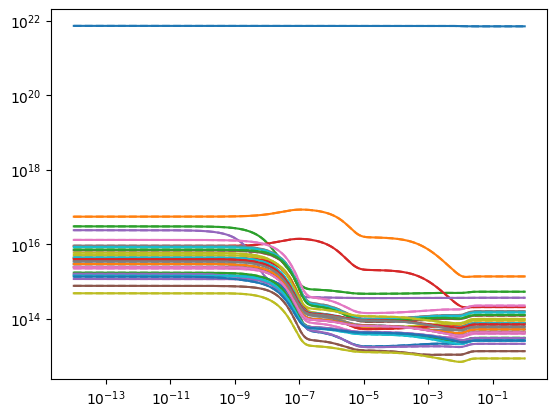

Arp


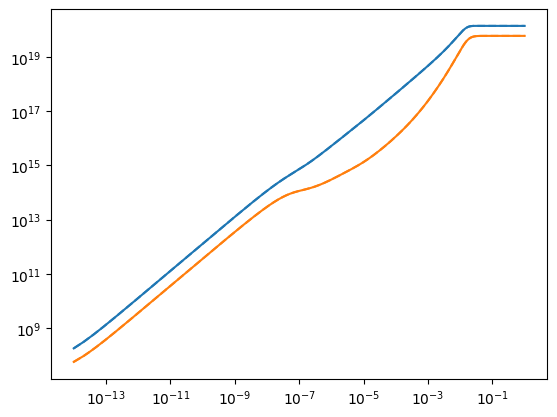

em


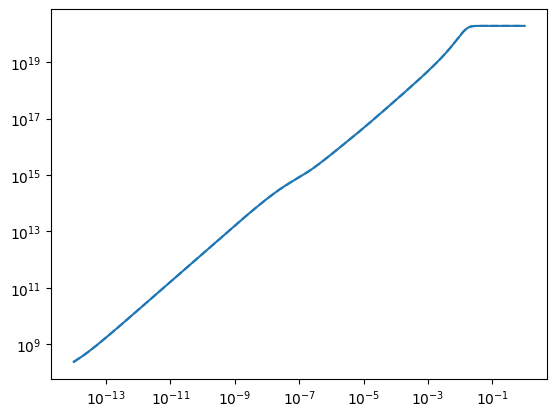

In [14]:
for s in model.mix.species.values():
  print(s.name)
  for i in s.indices:
    plt.loglog(t[1:], n_true[i][1:])
    plt.loglog(t[1:], n_pred[i][1:], ls="--", color=plt.gca().lines[-1].get_color())
  plt.show()
  plt.close()

In [15]:
# stop

Linear model

In [16]:
ylin, runtime = model.solve_fom(t, y0, rho, linear=True)
runtime

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9127314255980D-05   r2 =                  NaN


array([0.13767886])

In [17]:
n_lin, *T_lin = model.get_prim(ylin, clip=False)
nt_lin = n_lin.shape[1]

In [18]:
# def solve_lin(t, y0):
#   A = model.jac(0.0, y0)
#   b = model.fun(0.0, y0)
#   y = sp.integrate.solve_ivp(
#     fun=lambda t, y: A @ y + b,
#     t_span=[0.0,t[-1]],
#     y0=np.zeros_like(y0),
#     method="LSODA",
#     t_eval=t,
#     first_step=1e-14,
#     rtol=1e-6,
#     atol=1e-20,
#     jac=lambda t, y: A
#   ).y
#   y += y0.reshape(-1,1)
#   return y

In [19]:
# ylin = solve_lin(t, y0[:-2])

In [20]:
# for i, yi in enumerate(y.T):
#   A = model.jac(0.0, yi)
#   l, v = sp.linalg.eig(A.T)
#   stable = (l.real < 0.0).all()
#   if not stable:
#     print(np.where(l.real >= 0.0))
#     print(t[i], l.real.max())

In [21]:
# w_lin = copy.deepcopy(ylin[:model.mix.nb_comp])
# n_lin = model.mix.get_n(bkd.to_torch(w_lin)).numpy()

Ar
nan


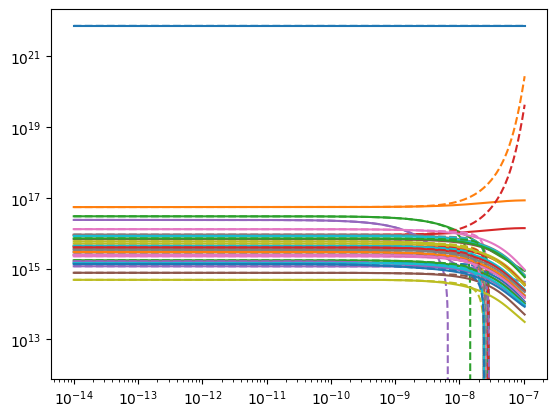

Arp
nan


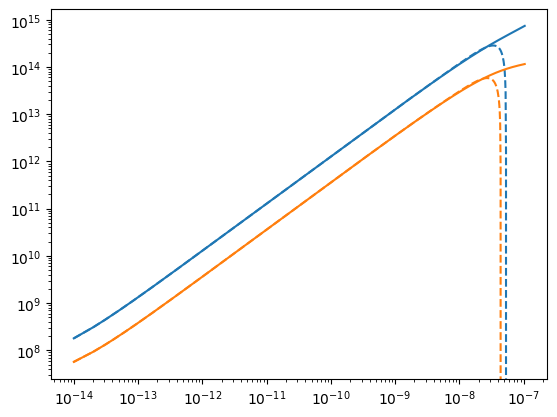

em
nan


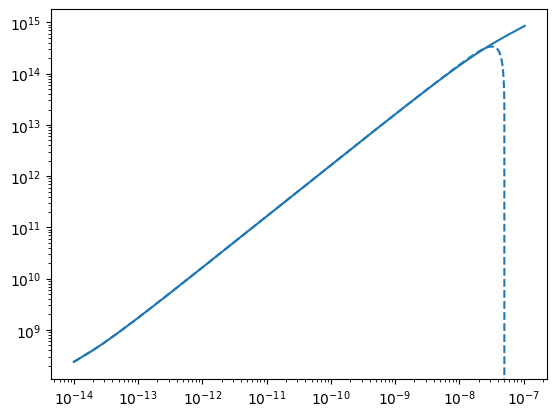

In [25]:
for s in model.mix.species.values():
  print(s.name)
  err = []
  for i in s.indices:
    ierr = np.mean(np.abs((n_pred[i][:nt_lin] - n_lin[i])/n_pred[i][:nt_lin]))
    err.append(ierr)
    plt.loglog(t[1:nt_lin-300], n_pred[i][1:nt_lin-300])
    plt.loglog(t[1:nt_lin-300], n_lin[i][1:-300], ls="--", color=plt.gca().lines[-1].get_color())
  print(np.mean(err))
  plt.show()
  plt.close()